# `iridl.ldeo.columbia.edu`

IRI Data Library (IRIDL) hosts various subseasonal initialized forecast, hindcast simulations and observations:
- `S2S project`:
    - http://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/
        - hindcast/reforecast: one variable, one model:
        - login required
- `SubX project`:
    - http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/
        - hindcast/reforecast: one variable, one model:
        - login not required
- `NOAA CPC` observations:
    - ground truth for `s2s-ai-challenge`
    - login not required
    - `pr`: http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/
    - `t2m`: http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/
---
- Notes:
    - Output on IRIDL is not always on the 1.5 degree grid requested for the competition. Also dimension names and coordinates differ.
    - Beware that most models are not only initialized on thursdays. It is not forbidden to use simulations which are started on other weekdays, buy please pay attention that you may only use information available on `forecast_time`, i.e. if the model is initialized on Mondays, you have to use the day 14+3=17 to day 27+3=30 forecast for week 3-4.
    - Beware that conventions (variable name, standard_name, coordinates, output format) from `SubX` and `S2S` might differ.
    - First check whether you can find 2020 `test` and previous `training` data for a given feature.
---
This notebook also provides opendap magic, i.e. commands added to the opendap URL which preprocess data server-side: select and aggregate `lead_time` `L` and `forecast_time` `S`. Regridding `X` and `Y`.

---

Todo:
- [ ] how to handle `hdate` best?
- [ ] how to not download empty `S`? specify weekly stride in `S` via ingrid

# `IRIDL` cookie

Here are instructions for configuring xarray to open protected Data Library datasets, after you have created a Data Library account and accepted the terms and conditions for the dataset.
1. Visit https://iridl.ldeo.columbia.edu/auth/genkey . Log in to the Data Library. Copy the key from the response.

2. Create a file with the following content, substituting the key from step 1 for `"xxxx"`:
`Set-Cookie: __dlauth_id=xxxx; domain=.iridl.ldeo.columbia.edu`

3. Put the following in `~/.daprc`, which is `/home/jovyan/.daprc` on renku, substituting the path to the above file for `/path/to/cookie/file`:
`HTTP.COOKIEJAR=/path/to/cookie/file`. You may need to copy `.daprc` to `/home/jovyan` on renku, because `/home/jovyan` is not tracked by `git`.

In [1]:
%%writefile /work/s2s-ai-challenge-template/.daprc
HTTP.COOKIEJAR=/work/s2s-ai-challenge-template/.cookie_iridl

Overwriting /work/s2s-ai-challenge-template/.daprc


In [2]:
!cp /work/s2s-ai-challenge-template/.daprc /home/jovyan

In [3]:
#%writefile /work/s2s-ai-challenge-template/.cookie_iridl
#Set-Cookie: __dlauth_id=xxxx; domain=.iridl.ldeo.columbia.edu

In [4]:
%%writefile /work/s2s-ai-challenge-template/.cookie_iridl
Set-Cookie: __dlauth_id=get_from_browser; domain=.iridl.ldeo.columbia.edu

Overwriting /work/s2s-ai-challenge-template/.cookie_iridl


In [5]:
import xarray as xr
xr.set_options(display_style='text')
import pandas as pd

/opt/conda/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


# S2S

Please beawre that most models are not only initialized on thursdays.
It is not forbidden to use simulations which are started on other weekdays,
buy please pay attention that you may only use information available on `forecast_time`,
i.e. if the model is initialized on Mondays, you have to use the day 14+3=17 to day 27+3=30 forecast for week 3-4.

In [6]:
ds = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.control/.2m_above_ground/.2t/dods',
                     chunks='auto', decode_times=False)

/opt/conda/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
/opt/conda/lib/python3.8/site-packages/gribapi/_bindings.cpython-38-x86_64-linux-gnu.so: undefined symbol: codes_bufr_key_is_header
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [7]:
# calendar '360' not recognized, but '360_day'
if ds.hdate.attrs['calendar'] == '360':
    ds.hdate.attrs['calendar'] = '360_day'

In [8]:
ds = xr.decode_cf(ds).rename({'X':'longitude', 'Y':'latitude', 'S':'forecast_time', 'LA': 'lead_time', '2t':'t2m'})
ds['t2m']

<xarray.DataArray 't2m' (hdate: 26, forecast_time: 641, lead_time: 46, latitude: 121, longitude: 240)>
dask.array<open_dataset-f89df07098f6ce22c120a08e3f3f29a52t, shape=(26, 641, 46, 121, 240), dtype=float32, chunksize=(7, 197, 12, 33, 60), chunktype=numpy.ndarray>
Coordinates:
  * latitude       (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * hdate          (hdate) object 1995-07-01 00:00:00 ... 2020-07-01 00:00:00
  * lead_time      (lead_time) timedelta64[ns] 0 days 12:00:00 ... 45 days 12...
  * forecast_time  (forecast_time) datetime64[ns] 2015-05-14 ... 2021-07-01
  * longitude      (longitude) float32 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
Attributes:
    pointwidth:      0
    gribPDSpattern:  04XXXX003D0000
    standard_name:   air_temperature
    long_name:       2-meter Temperature
    units:           K

In [9]:
ds.nbytes/1e9,'GB'

(89.052444908, 'GB')

In [10]:
# hdate gets the privous years reforecast for that dayofyear

## Hindcast Availability

- BOM:	BoM POAMA Ensemble.
- CMA:	Beijing Climate Center (BCC) Climate Prediction System for S2S.
- CNRM:	CNRM Ensemble Prediction System.
- ECCC:	ECCC Ensemble Prediction System.
- ECMF:	ECMWF Ensemble.
- HMCR:	HMCR Ensemble.
- ISAC:	ISAC-CNR Ensemble.
- JMA:	JMA Ensemble System.
- KMA:	KMA Seasonal Prediction System.
- NCEP:	NCEP CFSv2 Ensemble.
- UKMO:	UKMO Ensemble Prediction System.

In [11]:
models = ['BOM','CNRM','ECCC','ECMF','HMCR','ISAC','JMA','KMA','NCEP','UKMO']
for model in models:
    try:
        ds = xr.open_dataset(f'https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.{model}/.reforecast/.perturbed/.2m_above_ground/.2t/dods',
                             chunks='auto', decode_times=False).rename({'S':'forecast_time', 'LA':'lead_time','M':'realization', 'X':'longitude', 'Y':'latitude'})
        # calendar '360' not recognized, but '360_day'
        for c in ['hdate','forecast_time']:
            if c in ds.coords:
                if ds[c].attrs['calendar'] == '360':
                    ds[c].attrs['calendar'] = '360_day'
        ds = xr.decode_cf(ds)
        onthefly = True if 'hdate' in ds.coords else False
        forecast_time_freq = xr.infer_freq(ds.forecast_time)
        print(model, 'on-the-fly' if onthefly else 'not on-the-fly',
              'forecast_time freq:'+forecast_time_freq if forecast_time_freq else 'forecast_time freq not found',
              '\n',ds.coords,'\n',ds.sizes,ds.nbytes/1e9,'GB','\n')
    except Exception as e:
        print(f'model={model} failed due to {type(e).__name__}: {e} \n')

BOM not on-the-fly forecast_time freq not found 
 Coordinates:
  * latitude       (latitude) float32 88.1 85.64 83.16 ... -83.16 -85.64 -88.1
  * lead_time      (lead_time) timedelta64[ns] 0 days 12:00:00 ... 61 days 12...
  * forecast_time  (forecast_time) datetime64[ns] 1981-01-01 ... 2013-12-26
  * realization    (realization) float32 1.0 2.0 3.0 4.0 ... 29.0 30.0 31.0 32.0
  * longitude      (longitude) float32 0.0 2.507 5.014 ... 353.5 356.0 358.5 
 Frozen(SortedKeysDict({'latitude': 72, 'lead_time': 62, 'forecast_time': 2376, 'realization': 32, 'longitude': 144})) 195.498364944 GB 

CNRM not on-the-fly forecast_time freq not found 
 Coordinates:
  * latitude       (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 0 days 12:00:00 ... 60 days 12...
  * forecast_time  (forecast_time) datetime64[ns] 1993-01-01 ... 2014-12-15
  * realization    (realization) float32 1.0 2.0 3.0 4.0 ... 11.0 12.0 13.0 14.0
  * longitude      (lo

# SubX

The access to output from the SubX project does not require login information via cookie.

In [12]:
ds = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.CESM/.30LCESM1/.hindcast/.tas/dods',
                     chunks='auto', decode_times=False)

In [13]:
# calendar '360' not recognized, but '360_day'
if ds.S.attrs['calendar'] == '360':
    ds.S.attrs['calendar'] = '360_day'

In [14]:
ds = xr.decode_cf(ds).rename({'X':'longitude', 'Y':'latitude', 'S':'forecast_time', 'L': 'lead_time', 'M':'realization', 'tas':'t2m'})
ds['t2m']

<xarray.DataArray 't2m' (forecast_time: 887, realization: 10, lead_time: 45, latitude: 181, longitude: 360)>
dask.array<open_dataset-1bd5755a82e148fd83330ea4db46cbb8tas, shape=(887, 10, 45, 181, 360), dtype=float32, chunksize=(335, 2, 9, 61, 90), chunktype=numpy.ndarray>
Coordinates:
  * lead_time      (lead_time) timedelta64[ns] 0 days 12:00:00 ... 44 days 12...
  * latitude       (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * forecast_time  (forecast_time) datetime64[ns] 1999-01-06 ... 2015-12-30
  * realization    (realization) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
  * longitude      (longitude) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes:
    pointwidth:     0.0
    cell_methods:   time: mean
    units:          Kelvin_scale
    standard_name:  air_temperature
    long_name:      2-meter Air Temperature
    level_type:     2 meters above ground

In [15]:
ds.nbytes/1e9,'GB'

(104.03446566, 'GB')

## Hindcast Availability

- center: model
- CESM:	30LCESM1 46LCESM1
- ECCC:	GEM GEPS6 GEPS5
- EMC:	GEFS GEFSv12
- ESRL:	FIMr1p1
- GMAO:	GEOS_V2p1
- NCEP:	CFSv2
- NRL:	NESM
- RSMAS:	CCSM4

In [16]:
centers = ['CESM',   'CESM',  'ECCC', 'ECCC', 'ECCC', 'EMC', 'EMC',   'ESRL',    'GMAO'    , 'NCEP', 'NRL','RSMAS']
models = ['30LCESM1','46LCESM1','GEM','GEPS6','GEPS5','GEFS','GEFSv12','FIMr1p1','GEOS_V2p1','CFSv2','NESM','CCSM4']
for center,model in zip(centers,models):
    try:
        ds = xr.open_dataset(f'https://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.{center}/.{model}/.hindcast/.tas/dods',
                             chunks='auto', decode_times=False).rename({'S':'forecast_time', 'L':'lead_time','M':'realization', 'X':'longitude', 'Y':'latitude'})
        # calendar '360' not recognized, but '360_day'
        for c in ['hdate','forecast_time']:
            if c in ds.coords:
                if ds[c].attrs['calendar'] == '360':
                    ds[c].attrs['calendar'] = '360_day'
        ds = xr.decode_cf(ds)
        onthefly = True if 'hdate' in ds.coords else False
        forecast_time_freq = xr.infer_freq(ds.forecast_time)
        print(model, 'on-the-fly' if onthefly else 'not on-the-fly',
              'forecast_time freq:'+forecast_time_freq if forecast_time_freq else 'forecast_time freq not found',
              '\n',ds.coords,'\n',ds.sizes,ds.nbytes/1e9,'GB','\n')
    except Exception as e:
        print(f'center={center} model={model} failed due to {type(e).__name__}: {e} \n')

30LCESM1 not on-the-fly forecast_time freq:W-WED 
 Coordinates:
  * lead_time      (lead_time) timedelta64[ns] 0 days 12:00:00 ... 44 days 12...
  * latitude       (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * forecast_time  (forecast_time) datetime64[ns] 1999-01-06 ... 2015-12-30
  * realization    (realization) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
  * longitude      (longitude) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0 
 Frozen(SortedKeysDict({'lead_time': 45, 'latitude': 181, 'forecast_time': 887, 'realization': 10, 'longitude': 360})) 104.03446566 GB 

46LCESM1 not on-the-fly forecast_time freq:W-WED 
 Coordinates:
  * lead_time      (lead_time) timedelta64[ns] 0 days 12:00:00 ... 44 days 12...
  * latitude       (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * forecast_time  (forecast_time) datetime64[ns] 1999-01-06 ... 2015-12-30
  * realization    (realization) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
  * longitude      

# Opendap magic

Opendap URLs be appended for server-side preprocessing.

- https://www.opendap.org/support
- http://iridl.ldeo.columbia.edu/dochelp/topics/DODS/fnlist.html
- https://iridl.ldeo.columbia.edu/dochelp/Documentation/funcindex.html?Set-Language=en

## `curl` or `wget`

You can always work file-based and download from IRIDL via `curl` or `wget`. However, nicer is direct access via `opendap` and `xarray`.

In [17]:
from subprocess import call
fname = 'GEFS_pra_hc.nc'
# endless magic commands selecting week 3-4 and aggregating pr to tp with unit conversion
dset_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.EMC/.GEFS/.hindcast/.pr/S/(0000%206%20Jan%201999)/(0000%2028%20Dec%202015)/RANGEEDGES/S/(days%20since%201999-01-01)/streamgridunitconvert/Y/1/20/RANGE/X/-20/10/RANGE/L/(14)/(28)/RANGEEDGES/%5BL%5Daverage/S/(Jun-Aug)/VALUES/SOURCES/.Models/.SubX/.EMC/.GEFS/.hindcast/.dc9915/.pr/Y/1/20/RANGE/X/-20/10/RANGE/L/(14)/(28)/RANGEEDGES/%5BL%5Daverage/S/to366daysample/%5BYR%5Daverage/S/sampleDOY/sub/c%3A/0.001/(m3%20kg-1)/%3Ac/mul/c%3A/1000/(mm%20m-1)/%3Ac/mul/c%3A/86400/(s%20day-1)/%3Ac/mul/c%3A/7.0//units//days/def/%3Ac/mul/data.nc'
# download data with curl
call(['curl','-k',dset_url, '-o',fname])

0

In [18]:
ds = xr.open_dataset(fname).rename({'X':'longitude', 'Y':'latitude', 'S':'forecast_time', 'M':'realization', 'aprod':'tp'}).assign_coords(lead_time=pd.Timedelta('14 d'))
ds

<xarray.Dataset>
Dimensions:        (forecast_time: 226, latitude: 20, longitude: 31, realization: 11)
Coordinates:
  * latitude       (latitude) float32 1.0 2.0 3.0 4.0 ... 17.0 18.0 19.0 20.0
  * forecast_time  (forecast_time) datetime64[ns] 1999-06-02 ... 2015-08-26
  * realization    (realization) float32 0.0 1.0 2.0 3.0 ... 7.0 8.0 9.0 10.0
  * longitude      (longitude) float32 -20.0 -19.0 -18.0 -17.0 ... 8.0 9.0 10.0
    lead_time      timedelta64[ns] 14 days
Data variables:
    tp             (realization, forecast_time, latitude, longitude) float64 ...

## opendap

In [19]:
# server-side aggregate w34 precip to tp and regrid to 1.5 degree
forecast = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.EMC/.GEFS/.hindcast/.pr/S/(0000%206%20Jan%202000)/(0000%2031%20Dec%202019)/RANGEEDGES/L/(14)/(28)/RANGEEDGES/[L]average/X/0/1.5/358.5/GRID/Y/90/1.5/-90/GRID/dods',
                     chunks='auto').rename({'X':'longitude', 'Y':'latitude', 'S':'forecast_time', 'M':'realization', 'pr':'tp'}).assign_coords(lead_time=pd.Timedelta('14 d'))
print(forecast.nbytes/1e9, 'GB')

forecast = forecast * 3600 * 24 * 14 # convert from kg m-2 s-1 to to kg m-2 14day-1
forecast['tp'].attrs.update({'units':'kg m-2', 'long_name': 'total precipitation'})  # omitting biweekly is units
forecast.tp

1.132103944 GB


<xarray.DataArray 'tp' (forecast_time: 886, realization: 11, latitude: 121, longitude: 240)>
dask.array<mul, shape=(886, 11, 121, 240), dtype=float32, chunksize=(443, 6, 102, 120), chunktype=numpy.ndarray>
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-12 ... 2016-12-28
  * realization    (realization) float32 0.0 1.0 2.0 3.0 ... 7.0 8.0 9.0 10.0
  * longitude      (longitude) float32 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * latitude       (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
    lead_time      timedelta64[ns] 14 days
Attributes:
    units:      kg m-2
    long_name:  total precipitation

### create `forecast_like_observations` from observations with `time` dimension

[climetlab_s2s_ai_challenge.extra.forecast_like_observations](https://github.com/ecmwf-lab/climetlab-s2s-ai-challenge/blob/47539214d78251e30b79bd4b0dbb4a6a085cc9bf/climetlab_s2s_ai_challenge/extra.py#L43)

In [20]:
import climetlab as cml
from climetlab_s2s_ai_challenge.extra import forecast_like_observations, create_valid_time_from_forecast_time_and_lead_time

In [21]:
# download precipitation_flux pr
obs_ds = cml.load_dataset('s2s-ai-challenge-observations', parameter='pr').to_xarray()

obs_ds

By downloading data from this dataset, you agree to the terms and conditions defined at https://apps.ecmwf.int/datasets/data/s2s/licence/. If you do not agree with such terms, do not download the data.  This dataset has been dowloaded from IRIDL. By downloading this data you also agree to the terms and conditions defined at https://iridl.ldeo.columbia.edu.


100%|██████████| 1/1 [00:00<00:00, 147.08it/s]
/opt/conda/lib/python3.8/site-packages/climetlab/readers/__init__.py:86: UserWarning: Error loading wrapper grib: /opt/conda/lib/python3.8/site-packages/gribapi/_bindings.cpython-38-x86_64-linux-gnu.so: undefined symbol: codes_bufr_key_is_header
  warnings.warn(f"Error loading wrapper {name}: {e}")


<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 8154)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2021-04-28
  * latitude   (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
Data variables:
    pr         (time, latitude, longitude) float32 ...
Attributes:
    source_dataset_name:  NOAA NCEP CPC UNIFIED_PRCP GAUGE_BASED GLOBAL v1p0 ...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile

In [22]:
# less data heavy example: reduce forecast
forecast = forecast.sel(forecast_time='2000', realization=[0, 1]).expand_dims('lead_time')

In [23]:
# assign valid_time to forecasts
forecast = forecast.assign_coords(valid_time=create_valid_time_from_forecast_time_and_lead_time(forecast.forecast_time, forecast.lead_time))

In [24]:
# create an empty daily lead_time forecast dataset to input into forecast_like_observations, which requires continuous daily leads, first lead_time stays empty
dummy_forecast_daily = forecast.coords.to_dataset().isel(lead_time=[0]*30).assign_coords(lead_time=[pd.Timedelta(f'{i} d') for i in range(13,13+30)])
dummy_forecast_daily

<xarray.Dataset>
Dimensions:        (forecast_time: 51, latitude: 121, lead_time: 30, longitude: 240, realization: 2)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-12 ... 2000-12-27
  * realization    (realization) float32 0.0 1.0
  * longitude      (longitude) float32 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * latitude       (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 13 days 14 days ... 42 days
    valid_time     (lead_time, forecast_time) datetime64[ns] 2000-01-26 ... 2...
Data variables:
    *empty*
Attributes:
    Conventions:  IRIDL

In [25]:
# create tp from pr and creates forecast_time and lead_time from valid_time
obs_lead_time_forecast_time = forecast_like_observations(dummy_forecast_daily, obs_ds)
obs_lead_time_forecast_time

<xarray.Dataset>
Dimensions:        (forecast_time: 51, latitude: 121, lead_time: 30, longitude: 240)
Coordinates:
  * lead_time      (lead_time) timedelta64[ns] 13 days 14 days ... 42 days
    valid_time     (lead_time, forecast_time) datetime64[ns] 2000-01-26 ... 2...
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-12 ... 2000-12-27
Data variables:
    tp             (lead_time, forecast_time, latitude, longitude) float32 na...
Attributes:
    source_dataset_name:  NOAA NCEP CPC UNIFIED_PRCP GAUGE_BASED GLOBAL v1p0 ...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile
    function:             climetlab_s2s_ai_challenge.extra.forecast_like_obse...

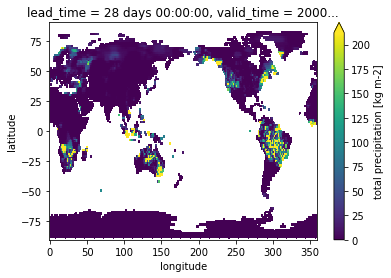

In [26]:
obs_lead_time_forecast_time.isel(forecast_time=0, lead_time=15).tp.plot(robust=True)

In [27]:
%time forecast = forecast.isel(forecast_time=0, lead_time=0, realization=0).load()

CPU times: user 5.2 s, sys: 2.17 s, total: 7.37 s
Wall time: 18.2 s


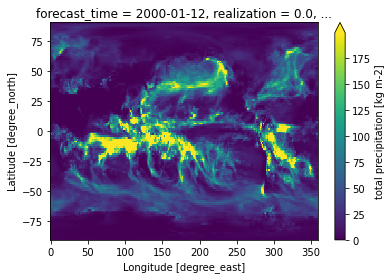

In [28]:
forecast.tp.plot(robust=True)

## speedtest

In [29]:
%%time
# speedtest: for one variable to download: server-side lead aggregate and regrid: 1.1 GB to download
forecast = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.EMC/.GEFS/.hindcast/.pr/S/(0000%206%20Jan%202000)/(0000%2031%20Dec%202019)/RANGEEDGES/L/(14)/(28)/RANGEEDGES/[L]average/X/0/1.5/358.5/GRID/Y/90/1.5/-90/GRID/dods',
                     chunks='auto').rename({'X':'longitude', 'Y':'latitude', 'S':'forecast_time', 'M':'realization', 'pr':'tp'}).assign_coords(lead_time=pd.Timedelta('14 d'))
print(forecast.nbytes/1e9, 'GB')
forecast = forecast.load()

1.132103944 GB
CPU times: user 21.6 s, sys: 12.8 s, total: 34.4 s
Wall time: 9min 47s


# IRIDL `intake` 

Build [`intake` catalogs](https://intake.readthedocs.io/en/latest/catalog.html#yaml-format) to access `S2S` and `SubX` model output easier by reducing download size with server-side preprocessing. Preprocessed data is opened via `opendap` in `xarray`.

Note that `lead_time` aggregation here is not fine-tuned for parameters to directly match biweekly aggregates.

## SubX

In [30]:
%%writefile SubX_catalog.yml
plugins:
  source:
    - module: intake_xarray

sources:
  training-input:
    description: SubX hindcasts from IRIDL regridded to 1.5 deg grid and aggregated by mean over lead, http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/outline.html
    driver: opendap
    parameters:
      center:
        description: name of the center issuing the hindcast
        type: str
        default: EMC
        allowed: [CESM, ECCC, EMC, ESRL, GMAO, NCEP, NRL, RSMAS]
      model:
        description: name of the model
        type: str
        default: GEFS
        allowed: [30LCESM1, 46LCESM1, GEM, GEPS6, GEPS5, GEFS, GEFSv12, FIMr1p1, GEOS_V2p1, CFSv2, NESM, CCSM4]
      grid:
        description: regrid to this global resolution
        type: float
        default: 1.5
      lead_start:
        description: aggregation start lead passed to RANGEEDGES
        type: int
        default: 14
      lead_end:
        description: aggregation end lead passed to RANGEEDGES
        type: int
        default: 27        
      param:
        description: variable name
        type: str
        default: pr
        #allowed: [pr]
    xarray_kwargs:
        engine: netcdf4
    args:
      urlpath: http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.{{center}}/.{{model}}/.hindcast/.{{param}}/L/({{lead_start}})/({{lead_end}})/RANGEEDGES/[L]average/X/0/{{grid}}/358.5/GRID/Y/90/{{grid}}/-90/GRID/dods

  test-input:
    description: SubX forecasts from IRIDL regridded to 1.5 deg grid and aggregated by mean over lead, http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/outline.html
    driver: opendap
    parameters:
      center:
        description: name of the center issuing the forecast
        type: str
        default: EMC
        allowed: [CESM, ECCC, EMC, ESRL, GMAO, NCEP, NRL, RSMAS]
      model:
        description: name of the model
        type: str
        default: GEFS
        allowed: [30LCESM1, 46LCESM1, GEM, GEPS6, GEPS5, GEFS, GEFSv12, FIMr1p1, GEOS_V2p1, CFSv2, NESM, CCSM4]
      grid:
        description: regrid to this global resolution
        type: float
        default: 1.5
      lead_start:
        description: aggregation start lead passed to RANGEEDGES
        type: int
        default: 14
      lead_end:
        description: aggregation end lead passed to RANGEEDGES
        type: int
        default: 27        
      param:
        description: variable name, see http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/outline.html
        type: str
        default: pr
        #allowed: [pr] 
    xarray_kwargs:
        engine: netcdf4
    args:
        urlpath: http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.{{center}}/.{{model}}/.forecast/.{{param}}/S/(0000%201%20Jan%202020)/(0000%2031%20Dec%202020)/RANGEEDGES/L/({{lead_start}})/({{lead_end}})/RANGEEDGES/[L]average/X/0/{{grid}}/358.5/GRID/Y/90/{{grid}}/-90/GRID/dods

Overwriting SubX_catalog.yml


In [31]:
import intake
import xarray as xr
import pandas as pd
import intake_xarray
cat = intake.open_catalog('SubX_catalog.yml')

In [32]:
def load_SubX_one_lead(dataset='training-input', **cat_kwargs):
    url = cat[dataset](**cat_kwargs).urlpath
    # cat[dataset].to_dask() is somehow slow
    ds = intake_xarray.OpenDapSource(url, engine='netcdf4').to_dask()
    ds = ds.rename({'X':'longitude', 'Y':'latitude', 'S':'forecast_time', 'M':'realization'})
    return ds

def load_SubX(dataset='training-input', **cat_kwargs):
    lead_1 = load_SubX_one_lead(dataset=dataset, lead_start=14, lead_end=27, **cat_kwargs).load()
    lead_2 = load_SubX_one_lead(dataset=dataset, lead_start=28, lead_end=41, **cat_kwargs).load()
    ds = xr.concat([lead_1, lead_2], 'lead_time')
    ds = ds.assign_coords(lead_time=[pd.Timedelta(f'{i} d') for i in [14, 28]])
    return ds

#load_SubX_one_lead(lead_start=28, lead_end=41)

In [33]:
# one variable two biweekly averages: hindcast
%time hindcast = load_SubX(dataset='training-input')

hindcast

CPU times: user 41.8 s, sys: 29.3 s, total: 1min 11s
Wall time: 6min 29s


<xarray.Dataset>
Dimensions:        (forecast_time: 939, latitude: 121, lead_time: 2, longitude: 240, realization: 11)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 1999-01-06 ... 2016-12-28
  * realization    (realization) float32 0.0 1.0 2.0 3.0 ... 7.0 8.0 9.0 10.0
  * longitude      (longitude) float32 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * latitude       (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
Data variables:
    pr             (lead_time, forecast_time, realization, latitude, longitude) float32 ...
Attributes:
    Conventions:  IRIDL

In [34]:
hindcast.nbytes/1e9,'GB'

(2.399642296, 'GB')

In [35]:
# one variable two biweekly averages: forecast
%time forecast = load_SubX(dataset='test-input')

forecast

CPU times: user 30.5 s, sys: 17.8 s, total: 48.3 s
Wall time: 3min 13s


<xarray.Dataset>
Dimensions:        (forecast_time: 366, latitude: 121, lead_time: 2, longitude: 240, realization: 21)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-01 ... 2020-12-31
  * realization    (realization) float32 0.0 1.0 2.0 3.0 ... 17.0 18.0 19.0 20.0
  * longitude      (longitude) float32 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * latitude       (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
Data variables:
    pr             (lead_time, forecast_time, realization, latitude, longitude) float32 ...
Attributes:
    Conventions:  IRIDL

In [36]:
forecast.nbytes/1e9,'GB'

(1.785615992, 'GB')

## S2S

In [37]:
%%writefile S2S_catalog.yml
plugins:
  source:
    - module: intake_xarray

sources:
  training-input:
    description: S2S hindcasts from IRIDL regridded to 1.5 deg grid and aggregated by mean over lead, https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/overview.html
    driver: opendap
    parameters:
      center:
        description: name of the center issuing the hindcast
        type: str
        default: ECMF
        allowed: [BOM, CNRM, ECCC, ECMF, HMCR, ISAC, JMA, KMA, NCEP, UKMO]
      grid:
        description: regrid to this global resolution
        type: float
        default: 1.5
      lead_name:
        description: name of the lead_time dimension
        type: str
        default: LA
        allowed: [LA, L]
      lead_start:
        description: aggregation start lead passed to RANGEEDGES
        type: int
        default: 14
      lead_end:
        description: aggregation end lead passed to RANGEEDGES
        type: int
        default: 27
      experiment_type:
        description: type of experiment
        type: str
        default: perturbed
        allowed: [control, perturbed, RMMS]
      group:
        description: group of variables
        type: str
        default: 2m_above_ground
        #allowed: [2m_above_ground, ...] see https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/
      param:
        description: variable name
        type: str
        default: 2t
        #allowed: [2t] see https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/
    xarray_kwargs:
        engine: netcdf4
    args:
      urlpath: http://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.{{center}}/.reforecast/.{{experiment_type}}/.{{group}}/{{param}}/{{lead_name}}/({{lead_start}})/({{lead_end}})/RANGEEDGES/[{{lead_name}}]average/X/0/{{grid}}/358.5/GRID/Y/90/{{grid}}/-90/GRID/dods


  test-input:
    description: S2S forecasts from IRIDL regridded to 1.5 deg grid and aggregated by mean over lead, https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/overview.html
    driver: opendap
    parameters:
      center:
        description: name of the center issuing the hindcast
        type: str
        default: ECMF
        allowed: ['BOM','CNRM','ECCC','ECMF','HMCR','ISAC','JMA','KMA','NCEP','UKMO']
      grid:
        description: regrid to this global resolution
        type: float
        default: 1.5
      lead_name:
        description: name of the lead_time dimension
        type: str
        default: LA
        allowed: [LA, L, L1]
      lead_start:
        description: aggregation start lead passed to RANGEEDGES
        type: int
        default: 14
      lead_end:
        description: aggregation end lead passed to RANGEEDGES
        type: int
        default: 27
      experiment_type:
        description: type of experiment
        type: str
        default: perturbed
        allowed: [control, perturbed, RMMS]
      group:
        description: group of variables
        type: str
        default: 2m_above_ground
        #allowed: see https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/
      param:
        description: variable name
        type: str
        default: 2t
        #allowed: [2t] see https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/
    xarray_kwargs:
        engine: netcdf4
    args:
        urlpath: http://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.{{center}}/.forecast/.{{experiment_type}}/.{{group}}/{{param}}/S/(0000%201%20Jan%202020)/(0000%2031%20Dec%202020)/RANGEEDGES/{{lead_name}}/({{lead_start}})/({{lead_end}})/RANGEEDGES/[{{lead_name}}]average/X/0/{{grid}}/358.5/GRID/Y/90/{{grid}}/-90/GRID/dods 

Overwriting S2S_catalog.yml


In [38]:
import intake
import xarray as xr
import pandas as pd
import intake_xarray
cat = intake.open_catalog('S2S_catalog.yml')

In [39]:
def load_S2S_one_lead(dataset='training-input', **cat_kwargs):
    cat = intake.open_catalog('S2S_catalog.yml')
    url = cat[dataset](**cat_kwargs).urlpath
    # cat[dataset].to_dask() is somehow slow
    ds = intake_xarray.OpenDapSource(url, engine='netcdf4', decode_times=False).to_dask()
    # calendar '360' not recognized, but '360_day'
    if 'hdate' in ds.coords:
        if ds.hdate.attrs['calendar'] == '360':
            ds.hdate.attrs['calendar'] = '360_day'

    ds = xr.decode_cf(ds).rename({'X':'longitude', 'Y':'latitude', 'S':'forecast_time'})
    
    if 'M' in ds.coords:
        ds = ds.rename({'M': 'realization'})
    
    #aggregated before
    #for c in ['LA', 'L', 'L1']:
    #    if c in ds.coords:
    #        ds = ds.rename({c:'lead_time'})
    
    #rename_data_var_dict = {'2t':'t2m'}
    #for v in rename_data_var_dict.keys():
    #    if v in ds.data_vars:
    #        ds = ds.rename({v: rename_data_var_dict[v]})
    return ds

def load_S2S(dataset='training-input', **cat_kwargs):
    lead_1 = load_S2S_one_lead(dataset=dataset, lead_start=14, lead_end=27, **cat_kwargs).load()
    lead_2 = load_S2S_one_lead(dataset=dataset, lead_start=28, lead_end=41, **cat_kwargs).load()
    ds = xr.concat([lead_1, lead_2], 'lead_time')
    ds = ds.assign_coords(lead_time=[pd.Timedelta(f'{i} d') for i in [14, 28]])
    return ds

#load_S2S_one_lead(dataset='training-input', lead_start=28, lead_end=41, center='BOM', experiment_type='control').nbytes/1e9

In [40]:
# one variable two biweekly averages: hindcast, reduce download size by taking control (without realizations)
%time hindcast = load_S2S(dataset='training-input', center='BOM', experiment_type='control')
hindcast

CPU times: user 9.31 s, sys: 3.97 s, total: 13.3 s
Wall time: 33.1 s


<xarray.Dataset>
Dimensions:        (forecast_time: 2376, latitude: 121, lead_time: 2, longitude: 240)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 1981-01-01 ... 2013-12-26
  * longitude      (longitude) float32 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * latitude       (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
Data variables:
    2t             (lead_time, forecast_time, latitude, longitude) float32 23...
Attributes:
    Conventions:  IRIDL

In [41]:
hindcast.nbytes/1e9

0.552012788

In [ ]:
# one variable two biweekly averages: forecast
# * 14 converts mean to sum
%time forecast = load_S2S(dataset='test-input', param='tp', group='sfc_precip', lead_name='L1', center='BOM') * 14

forecast

In [ ]:
forecast.nbytes/1e9,'GB'

# observations

Shows how observations with `time` dimension are downloaded from `IRIDL`. Use [`climetlab_s2s_ai_challenge.extra.forecast_like_observations`](https://github.com/ecmwf-lab/climetlab-s2s-ai-challenge/blob/47539214d78251e30b79bd4b0dbb4a6a085cc9bf/climetlab_s2s_ai_challenge/extra.py#L43) to convert to observations like forecasts `forecast-like-observations` with `lead_time` and `forecast_time` dimensions and `valid_time` coordinate.

In [1]:
import xarray as xr
xr.set_options(display_style='text')
import pandas as pd

/opt/conda/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


## `t2m`

http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/

In [2]:
chunk_dim='T'
grid=1.5
tmin = xr.open_dataset(f'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmin/T/(0000%201%20Jan%201999)/(0000%2001%20Apr%202021)/RANGEEDGES/X/0/{grid}/358.5/GRID/Y/90/{grid}/-90/GRID/dods', chunks={chunk_dim:100})
tmax = xr.open_dataset(f'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmax/T/(0000%201%20Jan%201999)/(0000%2001%20Apr%202021)/RANGEEDGES/X/0/{grid}/358.5/GRID/Y/90/{grid}/-90/GRID/dods', chunks={chunk_dim:100})

t = (tmin.rename({'tmin':'t'}) + tmax.rename({'tmax':'t'})) / 2

/opt/conda/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
/opt/conda/lib/python3.8/site-packages/gribapi/_bindings.cpython-38-x86_64-linux-gnu.so: undefined symbol: codes_bufr_key_is_header
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
t.T

<xarray.DataArray 'T' (T: 8126)>
array([2451180., 2451181., 2451182., ..., 2459303., 2459304., 2459305.],
      dtype=float32)
Coordinates:
  * T        (T) float32 2.451e+06 2.451e+06 2.451e+06 ... 2.459e+06 2.459e+06
Attributes:
    standard_name:  time
    pointwidth:     1
    calendar:       standard
    gridtype:       0
    units:          julian_day

In [4]:
t["T"] = pd.date_range(start="1999-01-01", freq="1D", periods=t.T.size)
t = t.rename({"X": "longitude", "Y": "latitude", "T": "time"})
t["t"].attrs = tmin["tmin"].attrs

# metadata
t = t.rename({"t": "t2m"})
t = t + 273.15
t["t2m"].attrs["units"] = "K"
t["t2m"].attrs["long_name"] = "2m Temperature"
t["t2m"].attrs["standard_name"] = "air_temperature"
t.attrs.update(
    {
        "source_dataset_name": "temperature daily from NOAA NCEP CPC: Climate Prediction Center",
        "source_hosting": "IRIDL",
        "source_url": "http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/",
    }
)
t

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 8126)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2021-03-31
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(100, 121, 240), meta=np.ndarray>
Attributes:
    source_dataset_name:  temperature daily from NOAA NCEP CPC: Climate Predi...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...

In [ ]:
%time t = t.load()

## `pr` to calc `tp`

http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/

In [5]:
rain = xr.open_dataset(f'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/T/(0000%201%20Jan%201999)/(0000%2001%20Apr%202021)/RANGEEDGES/X/0/{grid}/358.5/GRID/Y/90/{grid}/-90/GRID/dods', chunks={chunk_dim:100})

In [6]:
rain.T

<xarray.DataArray 'T' (T: 8127)>
array(['1999-01-01T00:00:00.000000000', '1999-01-02T00:00:00.000000000',
       '1999-01-03T00:00:00.000000000', ..., '2021-03-30T00:00:00.000000000',
       '2021-03-31T00:00:00.000000000', '2021-04-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * T        (T) datetime64[ns] 1999-01-01 1999-01-02 ... 2021-03-31 2021-04-01
Attributes:
    pointwidth:  0
    gridtype:    0

In [7]:
rain = rain.rename({"rain": "pr"}).rename({"X": "longitude", "Y": "latitude", "T": "time"})

# metadata pr
rain["pr"].attrs["units"] = "kg m-2 day-1"
rain["pr"].attrs["long_name"] = "precipitation flux"
rain["pr"].attrs["standard_name"] = "precipitation_flux"
rain.attrs.update(
    {
        "source_dataset_name": "NOAA NCEP CPC UNIFIED_PRCP GAUGE_BASED GLOBAL v1p0 extREALTIME rain: Precipitation data",
        "source_hosting": "IRIDL",
        "source_url": "http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain",
    }
)
rain

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 8127)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2021-04-01
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
Data variables:
    pr         (time, latitude, longitude) float32 dask.array<chunksize=(100, 121, 240), meta=np.ndarray>
Attributes:
    Conventions:          IRIDL
    source_dataset_name:  NOAA NCEP CPC UNIFIED_PRCP GAUGE_BASED GLOBAL v1p0 ...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...

In [ ]:
%time rain = rain.load()